# Übung 1: Berechnung einer absoluten Positionierung mit Code-Messungen

In [2]:
# Requirements 
# pip install git+https://github.com/GNSSpy-Project/gnsspy
# pip install pyunpack
# pip install georinex

# Libs
import gnsspy as gp
import numpy as np
import georinex
import geopandas
import matplotlib.pyplot as plt
import math

# Params
np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
plt.rcParams['figure.dpi'] = 300

In [12]:
%%capture
# Dataimport
station = gp.read_obsFile("./data/ONSA0320.11O")
ephemerides = georinex.load("./data/G3_11032.PRE")

# a) Groundtrack

In [13]:
def calculateLatLong(earth_fixed_coords):
    lat = list()
    lon = list()

    for x, y, z in earth_fixed_coords:
        lat.append(math.degrees(math.atan2(z, math.sqrt(x**2 + y**2)))) 
        lon.append(math.degrees(math.atan2(y, x)))

    return lat, lon

def plotGroundTrack(name, desc, lat, lon):
    countries = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

    countries.plot(color = "black")
    plt.scatter(lon, lat, color = "purple", s=2.5)

    minimum = round(min(lat), 4)
    maximum = round(max(lat), 4)

    plt.grid()
    plt.ylim(-90,90)
    plt.xlim(-180,180)
    plt.title(name + " " + desc)
    plt.figtext(0.5, 0.15, "Minimale Breite: " + str(minimum) + "° / maximale Breite: " + str(maximum) + "°", ha = "center", fontsize = 9, style = "italic")
    plt.show()

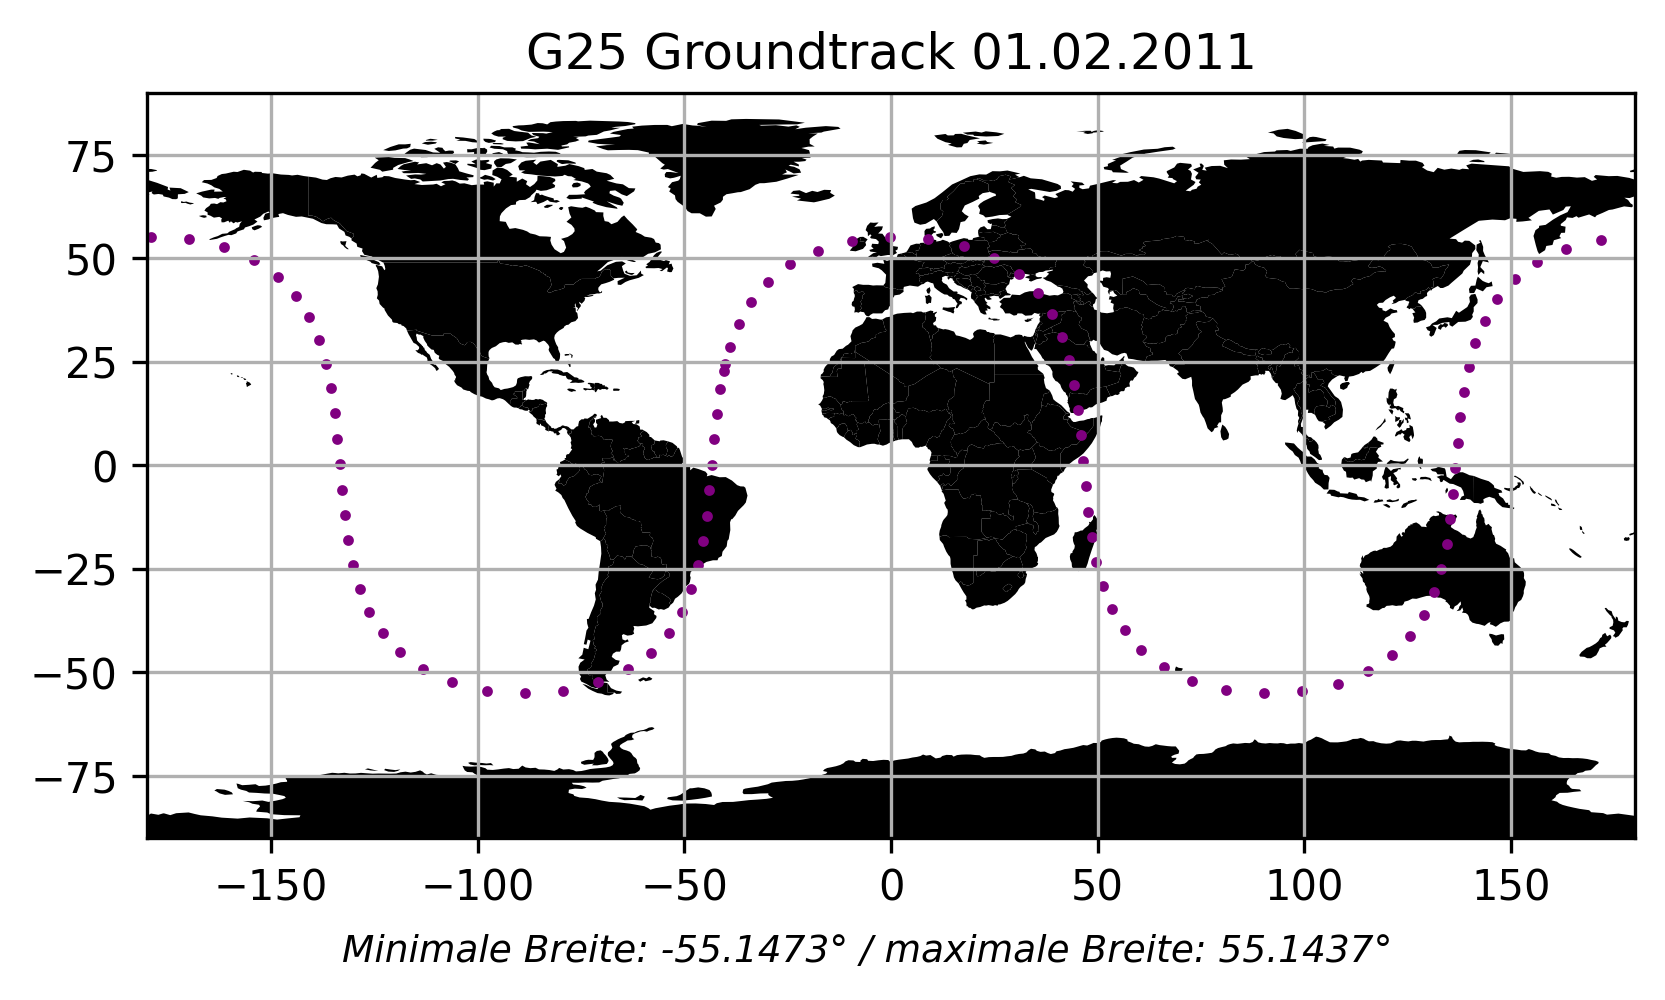

In [14]:
# Plot Groundtrack
lat, lon = calculateLatLong(ephemerides.sel(sv="G25").position)
plotGroundTrack("G25", "Groundtrack 01.02.2011", lat, lon)

Die Umlaufzeit beträgt ungefähr 12h. Dies kann man an der Anzahl an Beobachtungen (96, alle 15 Minuten eine über 24h) und der Bodenspur ableiten. Der Satellit macht von -180 bis 0 Grad ca. einen Umlauf, und dann nochmals für 0 bis 180 Grad. Weil nur 24h aufgezeichnet wurde, kann man darauf schliessen, dass der Satellit zwei Umläufe gemacht hat. Es kann auch die Umlaufzeit mit der grossen Halbachse des Orbits, der Gravitationskonstanste GM berechnet werden.

# b) Satellitenpositionen

In [15]:
# Load slice
ephemerides_interval = georinex.load("./data/G3_11032.PRE") #, tlim=['2011-02-01T00:00', '2011-02-01T01:00']) # this tlim is not working

# Consts
omega_e = 7.292115e-5 #s^-1
c = 299792458 #m/s

# Functions
def calculateSatPos(earth_fixed_coords, sat_velocities):
    earth_fixed_coords_si = earth_fixed_coords * 1000 # km to m
    sat_velocities_si = sat_velocities / 10 # dm/s to m/s
    
    sat_coords = list()
    for i, coord in enumerate(earth_fixed_coords_si):
        tau = math.dist(np.array(station.approx_position), coord) / c
        sat_coords.append(np.array(coord).T - np.array( (sat_velocities_si[i] + (omega_e * np.array([-coord[1], coord[0], 0]))) * tau))
        if i == 4: break # sorry this is a hack because tlim does not work

    return np.array(sat_coords)

In [16]:
# Calculate positions
sat_coords_at_send = calculateSatPos(ephemerides_interval.sel(sv="G25").position, ephemerides_interval.sel(sv="G25").velocity)

print("Geschätzte Koordinaten des Satelliten zum Zeitpunkt des Sendens: \n", sat_coords_at_send, "\nMit geschätzten Korrekturen: \n", np.array(ephemerides_interval.sel(sv="G25").position[0:5] * 1000 - sat_coords_at_send))

Geschätzte Koordinaten des Satelliten zum Zeitpunkt des Sendens: 
 [[ 18619309.35384 -15884993.13804  10299699.61402]
 [ 18131149.07678 -14641084.75531  12725495.93861]
 [ 17588720.66330 -13139931.11815  14932097.45722]
 [ 17031860.25051 -11396433.55019  16881479.00214]
 [ 16498097.89956 -9433722.64669  18540047.12587]] 
Mit geschätzten Korrekturen: 
 [[ 50.88616  199.65104  215.66698]
 [ 36.65522  214.20131  194.03639]
 [ 25.01370  227.09515  170.24478]
 [ 15.73449  238.11019  144.77886]
 [ 8.52444  247.09269  118.08213]]


# c) Zenitwinkel & troposphärische Verzögerung

In [17]:
# Coords of station in lat, lon
x, y, z = station.approx_position
lat_s = math.atan2(z, math.sqrt(x**2 + y**2))
lon_s = math.atan2(y, x)

#print(lat_s, lon_s)
print("Ungefähre Position von ONSA Groundstation aus Beobachtungsfile in IGS08 (EPSG:9014): \n", np.array((math.degrees(lat_s), math.degrees(lon_s)))) # in IGS08 (is weird, not correct on ONSA, in the ocean in front of ONSA)

Ungefähre Position von ONSA Groundstation aus Beobachtungsfile in IGS08 (EPSG:9014): 
 [ 57.22036  11.92551]


In [18]:
# Rotation matrices
def ry(a): return np.matrix([[np.cos(a), 0, -np.sin(a)], [0, 1, 0], [np.sin(a), 0, np.cos(a)]])
def rz(a): return np.matrix([[np.cos(a), np.sin(a), 0], [-np.sin(a), np.cos(a), 0], [0, 0, 1]])
r2 = ry((math.pi / 2) - lat_s)
r3 = rz(lon_s)

# Calculate N, E, U
n, e, u = list(), list(), list()
for coords in sat_coords_at_send:
    topo_coords = r2 @ r3 @ (coords - station.approx_position).T

    n.append(-topo_coords[0,0])
    e.append(topo_coords[0,1])
    u.append(topo_coords[0,2])

# Zenitwinkel
Zn = list()
for i in range(len(n)):
    Zn.append(math.degrees(math.atan2(math.sqrt(n[i]**2 + e[i]**2), u[i])) )

print("Zenitwinkel (deg) für G25 von ONSA am 01.02.2011 von 00:00 bis 01:00 (Intervall A):\n", np.array(Zn))

Zenitwinkel (deg) für G25 von ONSA am 01.02.2011 von 00:00 bis 01:00 (Intervall A):
 [ 63.26054  56.91762  50.43940  43.82655  37.08400]


In [19]:
# Tropospheric delay
def calculateTropDelay(angle):
    return 2.4 / math.cos(math.radians(angle))

vfunc = np.vectorize(calculateTropDelay)
print("Troposphärische Verzögerung im Intervall A: \n", vfunc(Zn))

Troposphärische Verzögerung im Intervall A: 
 [ 5.33411  4.39686  3.76829  3.32668  3.00845]


# d) Relativistische Effekte

In [20]:
# Relativistic delay
def calculateRelativistics(coord, velocity):
    #print(coord)
    return 2 * (coord @ velocity.T) / c

vel = np.array(ephemerides_interval.sel(sv="G25").velocity[0:5] / 10)

relativistics = list()
for i, coord in enumerate(sat_coords_at_send):
    relativistics.append(calculateRelativistics(coord, vel[i]))
print("Relativistische Effekte für G25 im Intervall:\n", np.array(relativistics))

Relativistische Effekte für G25 im Intervall:
 [-0.23053 -0.20452 -0.17429 -0.14040 -0.10353]
